# Body part classifier to be used in ensemble model

In [1]:
%load_ext autotime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet121
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models

from keras.utils import plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

import utils
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
def reshape(x):
    xs = x.shape
    return np.reshape(x, (xs[0], xs[1], xs[2], 1))

time: 1.14 ms


In [3]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()
x_train = reshape(utils.normalize_pixels(x_train))
x_test = reshape(utils.normalize_pixels(x_test))

print(x_train.shape)
size = x_train.shape[1]

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


(36808, 256, 256, 1)
time: 5.99 s


In [4]:
with Path('./data/MURA-v1.1/train_groups.pkl').open('rb') as pkl_file:
    train_groups = pickle.load(pkl_file)
with Path('./data/MURA-v1.1/valid_groups.pkl').open('rb') as pkl_file:
    valid_groups = pickle.load(pkl_file)

time: 16 ms


In [5]:
bodyparts = list(train_groups['body_part'].drop_duplicates())
bodyparts

['shoulder', 'humerus', 'finger', 'elbow', 'wrist', 'forearm', 'hand']

time: 6.53 ms


In [6]:
def target_bodypart_label(groups_df, bodyparts):
    for bp in bodyparts:
        groups_df.loc[:, bp] = groups_df['body_part'].str.contains(bp).astype(int)
    
    return groups_df[bodyparts].values

time: 1.34 ms


In [7]:
y_train = target_bodypart_label(train_groups, bodyparts)
y_test = target_bodypart_label(valid_groups, bodyparts)

time: 135 ms


In [8]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[1, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 2.24 ms


In [9]:
datagen.fit(x_train)

time: 3.99 s


In [10]:
with tf.device('/CPU:0'):
    dn121 = DenseNet121(input_shape=(256, 256, 1), classes=7, weights=None)

time: 10.1 s


In [11]:
model = multi_gpu_model(dn121, gpus=2)

time: 23.7 s


In [21]:
starting_epoch = 40
train_round = 0
batch_size = 60
epochs_per_eval = 10
epochs_per_save = 30
total_epochs = 400
history = {'loss': [], 'accuracy': [], 'valid_accuracy': []}

time: 4.37 ms


In [8]:
with tf.device('/CPU:0'):
    dn121 = models.load_model('./trained_models/3_1_body_part_classifier_40.h5')

model = multi_gpu_model(dn121, gpus=2)

time: 2min 4s


In [22]:
with open('./trained_models/3_1_body_part_classifier_history.pkl', 'rb') as pkl_file:
    history = pickle.load(pkl_file)

time: 2.62 ms


In [ ]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    print(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
    
    if train_round * epochs_per_eval + 1 + starting_epoch <= 100:
        opt = optimizers.Adam()
    else:
        lr = 0.001 * (0.9 ** train_round)
        opt = optimizers.sgd(lr=lr, momentum=0.9, nesterov=True)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        metrics=[metrics.categorical_accuracy])
    
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                           steps_per_epoch = len(x_train) / batch_size, epochs=epochs_per_eval, verbose=2)
    
    history['loss'].extend(model.history.history['loss'])
    history['accuracy'].extend(model.history.history['categorical_accuracy'])
    
    y_hat = model.predict(x_test)
    true_label = np.argmax(y_test, axis=1)
    pred_label = np.argmax(y_hat, axis=1)
    
    history['valid_accuracy'].append((true_label == pred_label).sum() / pred_label.shape[0])
    
    print(f"Valid Accuracy: {history['valid_accuracy'][-1]}")
    
    cur_epoch = (train_round+1) * epochs_per_eval
    if cur_epoch % epochs_per_save == 0:
        print(f'Saving Model to trained_models/3_1_body_part_classifier_{cur_epoch + starting_epoch}.h5...')
        model.save(f'./trained_models/3_1_body_part_classifier_{cur_epoch + starting_epoch}.h5')
    
    print('Saving evaluation metrics history...')
    with open('./trained_models/3_1_body_part_classifier_history.pkl', 'wb') as pkl_file:
        pickle.dump(history, pkl_file)
    
    train_round += 1

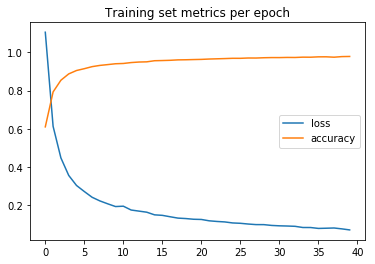

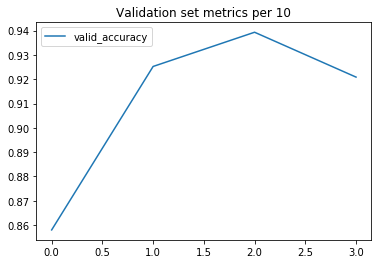

time: 280 ms


In [25]:
# Plots for epochs 0-40
train_metrics = ['loss', 'accuracy']
validation_metrics = ['valid_accuracy']
for metric in train_metrics:
    plt.plot(history[metric])
plt.title('Training set metrics per epoch')
plt.legend(train_metrics)
plt.show() 

for metric in validation_metrics:
    plt.plot(history[metric])
plt.title(f'Validation set metrics per {epochs_per_eval}')
plt.legend(validation_metrics)
plt.show() 

# Evaluate

In [9]:
y_hat = model.predict(x_test)
true_label = np.argmax(y_test, axis=1)
pred_label = np.argmax(y_hat, axis=1)

time: 32 s


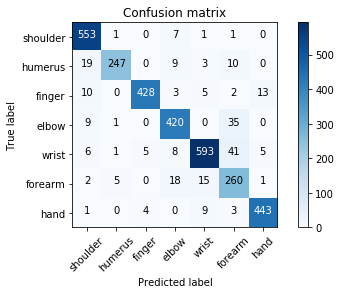

time: 287 ms


In [12]:
utils.plot_confusion_matrix(true_label, pred_label, classes=bodyparts)

In [18]:
def kappa(true_label, pred_label, num_classes):
    cm = confusion_matrix(true_label, pred_label)
    N = cm.sum()
    p_observed = np.sum([cm[i,i] for i in range(num_classes)]) / N
    p_expected = np.sum([cm[i, :].sum() * cm[:, i].sum() / N**2 for i in range(num_classes)])
    return (p_observed - p_expected) / (1 - p_expected)

time: 2.22 ms


In [19]:
kappa(true_label, pred_label, 7)

0.9066098471968383

time: 9.9 ms
